## Building the Model

Using a technique called 'transfer learning', I can use the InceptionV3 model which has been pretrained on a large dataset as a base model on top of which I can build and train my model on my dataset

In [1]:
pip install google-colab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#import libraries

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pickle
from google.colab import drive

In [3]:
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)
%cd /content/gdrive/My\ Drive/

Mounted at /content/gdrive
Mounted at /content/gdrive
/content/gdrive/My Drive


In [4]:
tree_of_heaven = len(os.listdir("Image Dataset/Image Dataset/Tree of Heaven"))
common_yarrow = len(os.listdir("Image Dataset/Image Dataset/Common Yarrow"))
purple_loosestrife = len(os.listdir("Image Dataset/Image Dataset/Purple Loosestrife"))
common_toadflax = len(os.listdir("Image Dataset/Image Dataset/Common Toadflax"))
english_ivy = len(os.listdir("Image Dataset/Image Dataset/English Ivy"))
blackthorn = len(os.listdir("Image Dataset/Image Dataset/Blackthorn"))
common_dogwood = len(os.listdir("Image Dataset/Image Dataset/Common Dogwood"))
cow_parsley = len(os.listdir("Image Dataset/Image Dataset/Cow Parsley"))
vipers_bugloss = len(os.listdir("Image Dataset/Image Dataset/Viper's Bugloss"))
bengal_rose = len(os.listdir("Image Dataset/Image Dataset/Bengal Rose"))

In [5]:
print("Tree of Heaven:", tree_of_heaven)
print("Common Yarrow:", common_yarrow)
print("Purple Loosestrife:", purple_loosestrife)
print("Common Toadflax:", common_toadflax)
print("English Ivy:", english_ivy)
print("Blackthorn:", blackthorn)
print("Common Dogwood:", common_dogwood)
print("Cow Parsley:", cow_parsley)
print("Viper's Bugloss:", vipers_bugloss)
print("Bengal Rose:", bengal_rose)
print("Total:", tree_of_heaven + common_yarrow + purple_loosestrife + common_toadflax + english_ivy + blackthorn + common_dogwood + cow_parsley + vipers_bugloss + bengal_rose) 

Tree of Heaven: 3000
Common Yarrow: 3000
Purple Loosestrife: 3000
Common Toadflax: 3000
English Ivy: 3000
Blackthorn: 3000
Common Dogwood: 3000
Cow Parsley: 3000
Viper's Bugloss: 3000
Bengal Rose: 3000
Total: 30000


In [6]:
data_path = "Image Dataset/Image Dataset"

#ImageDataGenerator imports the images from my dataset using the respective folder names as labels
datagen = ImageDataGenerator(
                            rescale=1./255,
                            validation_split=0.2) #splits the data 80% training and 20% validation

training_datagen = datagen.flow_from_directory(
                            data_path,
                            batch_size = 32,
                            target_size = (299,299), #preferred size for the InceptionV3 model
                            class_mode = "categorical",
                            subset = "training")
validation_datagen = datagen.flow_from_directory(
                            data_path,
                            batch_size = 32,
                            target_size = (299,299),
                            class_mode = "categorical",
                            subset = "validation")

print(training_datagen.class_indices)

Found 24000 images belonging to 10 classes.
Found 6000 images belonging to 10 classes.
{'Bengal Rose': 0, 'Blackthorn': 1, 'Common Dogwood': 2, 'Common Toadflax': 3, 'Common Yarrow': 4, 'Cow Parsley': 5, 'English Ivy': 6, 'Purple Loosestrife': 7, 'Tree of Heaven': 8, "Viper's Bugloss": 9}


In [7]:
from keras.applications.inception_v3 import InceptionV3

#instantiating pretrained InceptionV3 model
inception = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(299,299,3)
)

#Freezing all layers in the InceptionV3 model so that their values cannot be updated during training on my dataset
for layer in inception.layers:
    layer.trainable = False

#Adding a pooling and logistic layer for my model
x = GlobalAveragePooling2D()(inception.output)
predictions = Dense(10, activation = "softmax")(x)
model = Model(inputs = inception.input, outputs = predictions)

87924736/87910968 [==============================] - 0s 0us/step


In [8]:
# EarlyStopping stops training when the loss metric has not improved for 10 epochs
early_stopping = EarlyStopping(monitor = "val_loss", patience=10)

# ModelCheckpoint saves only the model with the highest accuracy so far
model_checkpoint = ModelCheckpoint("inception_model.h5", save_best_only=True, verbose=1, monitor='val_accuracy')

#compiling the model
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [9]:
history = model.fit(
    training_datagen,
    validation_data = validation_datagen,
    epochs=20,
    steps_per_epoch = training_datagen.samples//32, #number of images divided by the batch size
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
750/750 [==============================] - ETA: 0s - loss: 0.9057 - accuracy: 0.7028 
Epoch 1: val_accuracy improved from -inf to 0.77583, saving model to inception_model.h5
750/750 [==============================] - 10223s 14s/step - loss: 0.9057 - accuracy: 0.7028 - val_loss: 0.6787 - val_accuracy: 0.7758
Epoch 2/20
750/750 [==============================] - ETA: 0s - loss: 0.6143 - accuracy: 0.7983
Epoch 2: val_accuracy improved from 0.77583 to 0.78333, saving model to inception_model.h5
750/750 [==============================] - 125s 167ms/step - loss: 0.6143 - accuracy: 0.7983 - val_loss: 0.6476 - val_accuracy: 0.7833
Epoch 3/20
750/750 [==============================] - ETA: 0s - loss: 0.5334 - accuracy: 0.8245
Epoch 3: val_accuracy improved from 0.78333 to 0.80817, saving model to inception_model.h5
750/750 [==============================] - 124s 165ms/step - loss: 0.5334 - accuracy: 0.8245 - val_loss: 0.5819 - val_accuracy: 0.8082
Epoch 4/20
750/750 [================

In [10]:
with open('./InceptionTrainingHistory', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

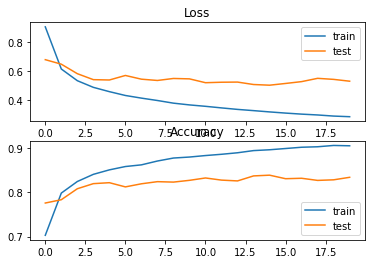

In [11]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()